In [ ]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from os import path
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score
from numpy import interp
from sklearn.metrics import confusion_matrix

def getPerfMeasures(y_test, y_prob, in_threshold):
    if in_threshold == -1:
        cm = confusion_matrix(y_test, y_prob >= 0.5)
    else:
        cm = confusion_matrix(y_test, y_prob >= in_threshold)

    TRUE_POSITIVE = cm[1][1]
    FALSE_NEGATIVE = cm[1][0]
    FALSE_POSITIVE = cm[0][1]
    TRUE_NEGATIVE = cm[0][0]

    if (TRUE_POSITIVE + FALSE_POSITIVE) == 0 or (TRUE_POSITIVE + FALSE_NEGATIVE) == 0 or ((TRUE_NEGATIVE + FALSE_POSITIVE) == 0) or (TRUE_NEGATIVE + FALSE_NEGATIVE) == 0:
        PR = 0
        mcc = 0
    else:
        PR = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
        mcc = ((TRUE_POSITIVE * TRUE_NEGATIVE) - (FALSE_POSITIVE * FALSE_NEGATIVE)) / (np.sqrt((TRUE_POSITIVE + FALSE_POSITIVE) * (TRUE_POSITIVE + FALSE_NEGATIVE) * (TRUE_NEGATIVE + FALSE_POSITIVE) * (TRUE_NEGATIVE + FALSE_NEGATIVE)))

    RE  = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
    SP  = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_POSITIVE)
    acc = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + FALSE_NEGATIVE + TRUE_NEGATIVE)
    F05 = getFScore(0.5,PR,RE)
    F1  = getFScore(1, PR, RE)
    F2  = getFScore(2, PR, RE)

    return PR, RE, SP, F1, F2, acc, mcc, cm, TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE

\
def data_normalize(row, mean_df, std_df, athlete_id):
    mu = mean_df.loc[athlete_id]
    su = std_df.loc[athlete_id]
    z = (row - mu)/su
    return z

# Calculate the means and standard deviations of all healthy events per athlete
def getStandardDeviationFromMean(data):
    mean = data[data['injury'] == 0].groupby('Athlete ID').mean()
    std = data[data['injury'] == 0].groupby('Athlete ID').std()
    std.replace(to_replace=0.0, value=0.01, inplace=True)
    return mean, std

# Calculate the F-score for a given beta value
def getFScore(beta,PR,RE):
    if PR == 0 and RE == 0:
        return 0
    else:
        return (1+(beta*beta))*(PR*RE)/((beta*beta*PR) + RE)
    
# Calculate the required statistical results
def getStatistics(y_test, y_pred, y_prob, in_threshold, show):
    auc = roc_auc_score(y_test, y_prob)

    fpr = np.linspace(0, 1, 101)
    fpr_org, tpr_org, thresholdold = metrics.roc_curve(y_test, y_prob)
    tpr = interp(fpr, fpr_org, tpr_org)

    if not in_threshold:
        n_threshold = len(thresholdold)
        prlist   = np.zeros(n_threshold)
        relist   = np.zeros(n_threshold)
        acclist  = np.zeros(n_threshold)
        mcclist  = np.zeros(n_threshold)
        F2list   = np.zeros(n_threshold)
        F1list   = np.zeros(n_threshold)
        SPlist   = np.zeros(n_threshold)
        for th in np.arange(n_threshold):
            prlist[th], relist[th], SPlist[th], F1list[th], F2list[th], acclist[th], mcclist[th], cm, TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = getPerfMeasures(y_test, y_prob, thresholdold[th])

        idx = np.argmin(np.abs(np.array(relist) - np.array(SPlist)))
        best_test_threshold = thresholdold[idx]

        PR, RE, SP, F1, F2, acc, mcc, cm, TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = getPerfMeasures(y_test, y_prob, best_test_threshold)
        stats = {"threshold": best_test_threshold, "auc": auc, "fpr": fpr, "tpr": tpr, "cm": cm}
    else:
        PR, RE, SP, F1, F2, acc, mcc, cm, TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = getPerfMeasures(y_test, y_prob, in_threshold)
        stats = {"threshold": in_threshold, "auc": auc, "fpr": fpr, "tpr": tpr, "cm": cm}

    return stats

: 

In [ ]:
# Load the data set    
def loadDataToTrain(approach):
    if (approach == "day"):
        df = pd.read_csv("/kaggle/input/smai-project/runner-dataset/day_approach_maskedID_timeseries.csv")
    elif (approach == "week"):
        df = pd.read_csv("/kaggle/input/smai-project/runner-dataset/week_approach_maskedID_timeseries.csv")        
    return df

# Sample with replacement a balanced subset from the training data 
def getBalancedSubset(input_train, samplesPerClass):
    NotInjuredSet   = pd.DataFrame
    InjuredSet = pd.DataFrame

    stats = pd.DataFrame(input_train[['Athlete ID','injury']].groupby(['Athlete ID','injury']).size().reset_index(name='counts'))
    stats = pd.DataFrame(stats[['Athlete ID']].groupby(['Athlete ID']).size().reset_index(name='counts'))
    stats.drop(stats[stats['counts'] < 2].index, inplace=True)
    athleteList = stats['Athlete ID'].unique()

    samplesPerAthlete = int(np.floor(samplesPerClass) / len(athleteList))

    for athlete in athleteList:
        if InjuredSet.empty:
            InjuredSet = input_train[(input_train['Athlete ID'] == athlete) & (input_train['injury'] == 0)].sample(samplesPerAthlete, replace=True)
        else:
            InjuredSet = pd.concat([InjuredSet, input_train[(input_train['Athlete ID'] == athlete) & (input_train['injury'] == 0)].sample(samplesPerAthlete,replace=True)])

        if NotInjuredSet.empty:
            NotInjuredSet = input_train[(input_train['Athlete ID'] == athlete) & (input_train['injury'] == 1)].sample(samplesPerAthlete, replace=True)
        else:
            NotInjuredSet = pd.concat([NotInjuredSet, input_train[(input_train['Athlete ID'] == athlete) & (input_train['injury'] == 1)].sample(samplesPerAthlete,replace=True)])


    balancedSet = pd.concat([NotInjuredSet, InjuredSet], ignore_index=True)
    return balancedSet


# Apply the bagging approach to new test data
def applyBagging(modelList, input_test, input_test_means, input_test_std, best_train_threshold, train_auc_list,filename):
    # Test the model on the test set
    y_predList = pd.DataFrame()
    y_probList = pd.DataFrame()
    fprList    = pd.DataFrame()
    tprList    = pd.DataFrame()
    auc_test_list = []

    y_test = np.array(input_test['injury']).astype(int)
    input_test = input_test.drop(columns=['injury', 'Date'])
    input_test = input_test.apply(lambda x: data_normalize(x, input_test_means, input_test_std, x['Athlete ID']), axis=1)
    input_test = input_test.drop(columns=['injury', 'Date','Athlete ID'], errors='ignore').to_numpy()

    for idx, model in enumerate(modelList):
        y_pred, y_prob = predictValues(input_test, model)        

        indices = np.where(np.array(y_pred) != None)
        y_test = np.array(y_test)[indices].astype(int)
        y_pred = np.array(y_pred)[indices].astype(int)
        y_prob = np.array(y_prob)[indices]
        y_predList['bag %d' %(idx+1)] = y_pred
        y_probList['bag %d' %(idx+1)] = y_prob

        stats = getStatistics(y_test, y_pred,y_prob, 0.5, False)    
        fprList['bag %d' % (idx + 1)] = stats["fpr"]
        tprList['bag %d' % (idx + 1)] = stats["tpr"]
        auc_test_list.append(stats["auc"])

    y_prob = y_probList.mean(axis = 1)
    y_pred = y_predList.mode(axis = 1)

    plotCalibrationCurve(y_test, y_prob,filename)

    val_stats = getStatistics(np.array(y_test).astype(int), np.array(y_pred).astype(int),np.array(y_prob), best_train_threshold, True)
    return val_stats["threshold"], val_stats["auc"], fprList.mean(axis=1), tprList.mean(axis=1), val_stats["cm"]



: 

In [3]:
# Train an XGBoost model with the given dftrain data and calibrate it with the given X_val data
def trainModel(params, dftrain, X_val, mean, std, calibrate):
    output_train    = np.array(dftrain['injury']).astype(int)
    output_val      = np.array(X_val['injury']).astype(int)

    data_train = dftrain.drop(columns=['injury', 'Date'])
    data_val   = X_val.drop(columns=['injury', 'Date'])

    '''Apply normalization to training set'''    
    data_train = data_train.apply(lambda x: data_normalize(x, mean, std, x['Athlete ID']), axis=1)
    data_val   = data_val.apply(lambda x: data_normalize(x, mean, std, x['Athlete ID']), axis=1)
    
    input_train    = data_train.drop(columns = ['injury', 'Date', 'Athlete ID'], errors='ignore').to_numpy()
    X_val      = data_val.drop(columns = ['injury', 'Date', 'Athlete ID'], errors='ignore').to_numpy()

    model      = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = 0.01,
                     max_depth = random.choice(params["XGBDepthList"]), 
                     n_estimators = random.choice(params["XGBEstimatorsList"]), 
                     importance_type = 'total_gain', eval_metric = 'auc', verbosity=1)
    model.fit(input_train, output_train)

    calib_model = CalibratedClassifierCV(model, method=calibrate, cv="prefit")
    calib_model.fit(X_val, output_val)

    return model, calib_model, X_val, output_val

In [4]:

# Plot a calibration with the given y_test and y_pred values
def plotCalibrationCurve(y_test, y_pred, filename):
    fig = plt.figure(1, figsize=(10, 10))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=10, strategy='quantile')

    plt.plot(mean_predicted_value, fraction_of_positives, "s-",label="XGBoost")
    plt.plot([0, 1],[0, 1], ls="--", c="0.3")
    plt.ylabel("Fraction of Positives")
    plt.xlabel("Predicted Probability")
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.legend(loc = "lower right")
    plt.title('Calibration plots  (reliability curve)')
    plt.savefig(filename)
    plt.close()

# Organize data in a structure that can be written to a csv file
def getVariablesForPrint(val_cm,test_cm):
    test_TRUE_POSITIVE = test_cm[1][1]
    test_FALSE_NEGATIVE = test_cm[1][0]
    test_FALSE_POSITIVE = test_cm[0][1]
    test_TRUE_NEGATIVE = test_cm[0][0]
    val_TRUE_POSITIVE  = val_cm[1][1]
    val_FALSE_NEGATIVE  = val_cm[1][0]
    val_FALSE_POSITIVE  = val_cm[0][1]
    val_TRUE_NEGATIVE  = val_cm[0][0]

    val_RE  = val_TRUE_POSITIVE  / (val_TRUE_POSITIVE  + val_FALSE_NEGATIVE)
    test_RE = test_TRUE_POSITIVE / (test_TRUE_POSITIVE + test_FALSE_NEGATIVE)
    val_SP  = val_TRUE_NEGATIVE  / (val_TRUE_NEGATIVE  + val_FALSE_POSITIVE)
    test_SP = test_TRUE_NEGATIVE / (test_TRUE_NEGATIVE + test_FALSE_POSITIVE)

    results = {"val_RE": val_RE,
               "val_SP": val_SP,
               "val_TRUE_POSITIVE": val_TRUE_POSITIVE,
               "val_FALSE_POSITIVE": val_FALSE_POSITIVE,
               "val_TRUE_NEGATIVE": val_TRUE_NEGATIVE,
               "val_FALSE_NEGATIVE": val_FALSE_NEGATIVE,
               "test_RE": test_RE,
               "test_SP": test_SP,
               "test_TRUE_POSITIVE": test_TRUE_POSITIVE,
               "test_FALSE_POSITIVE": test_FALSE_POSITIVE,
               "test_TRUE_NEGATIVE": test_TRUE_NEGATIVE,
               "test_FALSE_NEGATIVE": test_FALSE_NEGATIVE
              }
    return results

# Apply the given model to data_test
def predictValues(data_test, model):
    y_pred = model.predict(data_test)
    y_prob = model.predict_proba(data_test)

    return y_pred, y_prob[:, 1]


In [5]:
# Run experiment with given a parameters and approach (day or week)
def runExperiment(params, approach, exp):
    
    outdir = "%s_%d" %(approach,params["samplesPerClass"])
    
    # Load data set in a data frame
    df = loadDataToTrain(approach)

    # Sort athletes with ID
    athletes = sorted(list(df['Athlete ID'].unique()))

    #  Choose the last N athletes that joined the club and keep them as the test set
    test_athletes = athletes[len(athletes) - params["nTestAthletes"]:len(athletes)]
    input_test = df[df['Athlete ID'].isin(test_athletes)]
    input_test_means, input_test_std = getStandardDeviationFromMean(input_test)

    # Set the training data to be the vectors of all other athletes
    input_trainval = df[~df['Athlete ID'].isin(test_athletes)]
    input_train_means, input_train_std = getStandardDeviationFromMean(input_trainval)

    input_trainval_org = input_trainval
    modelList = []
    featureRanking = pd.DataFrame()
    aucList = np.zeros(params["nbags"])
    best_train_threshold = np.zeros(params["nbags"])

    # Run a bagging approach
    X_valorg = getBalancedSubset(input_trainval_org, params["samplesPerClass"])
    output_val_probList = pd.DataFrame()
    
    for bag in np.arange(params["nbags"]):
        input_train_bag = getBalancedSubset(input_trainval_org, params["samplesPerClass"])

        model, calib_model, X_val, output_val = trainModel(params, input_train_bag, X_valorg, input_train_means, input_train_std, params["calibrationType"])
        modelList.append(calib_model)

        output_val_prob = calib_model.predict_proba(X_val)
        plotCalibrationCurve(output_val, output_val_prob[:, 1],'./%s/calibrate_%d_%d.pdf' %(outdir,exp,bag))
        output_val_probList["Bag %d" %bag] = output_val_prob[:, 1]
        featureRanking["Bag %d" %bag] = model.feature_importances_

    plotCalibrationCurve(output_val, output_val_probList.mean(axis = 1),'./%s/calibrate_bagging_%d.pdf' % (outdir,exp))
    y_prediction = output_val_probList.mean(axis=1)
        
    outValBaggingFilename = "./%s/valbagging.csv" %(outdir)
    if path.exists(outValBaggingFilename):
        with open(outValBaggingFilename, 'a', newline='') as file:
            writer = csv.writer(file)
            for idx in np.arange(0,len(output_val)):
                writer.writerow(['%s' %(outdir),'%d' % (exp),output_val[idx],y_prediction[idx]])
    else:
        with open(outValBaggingFilename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Desc","Exp","Y_Val","Y_Pred"])
            for idx in np.arange(0,len(output_val)):
                writer.writerow(['%s' %(outdir),'%d' % (exp),output_val[idx],y_prediction[idx]])

    # print("****** Training Results ****")
    # Remove Athletese from the training set who do not have unhealthy or healthy events
    input_trainval_org = input_trainval_org.drop(input_trainval_org[~input_trainval_org['Athlete ID'].isin(input_train_bag['Athlete ID'].unique())].index, inplace=False)

    valSamples = input_trainval_org[input_trainval_org['injury'] == 0].sample(len(input_test[input_test['injury'] == 0]))
    valSamples = pd.concat([valSamples, input_trainval_org[input_trainval_org['injury'] == 1].sample(len(input_test[input_test['injury'] == 1]))])

    val_threshold, val_auc, val_fpr, val_tpr, val_cm = applyBagging(modelList, valSamples, input_train_means, input_train_std, [], aucList, './%s/calibrate_validation_%d.pdf' % (outdir, exp))

    # print("****** Test Results ****")
    test_threshold, test_auc, test_fpr, test_tpr, test_cm = applyBagging(modelList, input_test, input_test_means, input_test_std, val_threshold, aucList, './%s/calibrate_test_%d.pdf' % (outdir, exp))

    results     = getVariablesForPrint(val_cm, test_cm)
    writeResults(outdir, results, params, exp, test_threshold, test_auc, val_auc)
    
    # Aggregate feature importance and plot them
    aggFeatureRanking = featureRanking.sum(axis = 1)
    
    return aggFeatureRanking, input_train_bag.columns, val_fpr, val_tpr, val_auc, test_fpr, test_tpr, test_auc, output_val, y_prediction


In [6]:
# Write results to a CSV file
def writeResults(outdir, results, params, exp, test_thresh, test_auc, val_auc):
    resultsFilename = "./%s/results.csv" %(outdir)
    injuries    = results["val_TRUE_POSITIVE"] + results["val_FALSE_NEGATIVE"]
    noninjuries = results["val_TRUE_NEGATIVE"] + results["val_FALSE_POSITIVE"]
    
    if path.exists(resultsFilename):
        with open(resultsFilename, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([params["nTestAthletes"], params["nbags"], exp, injuries, noninjuries, test_thresh, val_auc, results["val_RE"], results["val_SP"], results["val_TRUE_POSITIVE"], results["val_FALSE_POSITIVE"], results["val_TRUE_NEGATIVE"], results["val_FALSE_NEGATIVE"], test_auc, results["test_RE"], results["test_SP"], results["test_TRUE_POSITIVE"], results["test_FALSE_POSITIVE"], results["test_TRUE_NEGATIVE"], results["test_FALSE_NEGATIVE"]])
    else:
        with open(resultsFilename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["N", "nbags", "exp", "injuries", "non-injuries", "thresh", "Val_AUC", "Val_RE", "Val_SP", "Val_TRUE_POSITIVE", "Val_FALSE_POSITIVE", "Val_TRUE_NEGATIVE", "Val_FALSE_NEGATIVE", "Test_AUC", "Test_RE", "Test_SP", "Test_TRUE_POSITIVE", "Test_FALSE_POSITIVE", "Test_TRUE_NEGATIVE", "Test_FALSE_NEGATIVE"])        
            writer.writerow([params["nTestAthletes"], params["nbags"], exp, injuries, noninjuries, test_thresh, val_auc, results["val_RE"], results["val_SP"], results["val_TRUE_POSITIVE"], results["val_FALSE_POSITIVE"], results["val_TRUE_NEGATIVE"], results["val_FALSE_NEGATIVE"], test_auc, results["test_RE"], results["test_SP"], results["test_TRUE_POSITIVE"], results["test_FALSE_POSITIVE"], results["test_TRUE_NEGATIVE"], results["test_FALSE_NEGATIVE"]])

# Plot the ROC curve and save to a file
def plotROC(val_fpr,val_tpr,val_auc,test_fpr,test_tpr,test_auc,filename):
    linewidth = 2
    plt.figure(figsize=(20, 10))
    plt.plot(val_fpr, val_tpr, color='darkorange',lw=linewidth, label='Validation (AUC = %0.4f)' %val_auc)
    plt.plot(test_fpr, test_tpr, color='darkgreen', lw=linewidth, label='Test (AUC = %0.4f)' %test_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig(filename)
    
    plt.close()

Approach = day, N = 10, nbags = 9, exp = 1
[0.73887442 0.         0.         0.         0.        ]
[0.72800935 0.         0.         0.         0.        ]
Approach = day, N = 10, nbags = 9, exp = 2
[0.73887442 0.69420174 0.         0.         0.        ]
[0.72800935 0.72424182 0.         0.         0.        ]
Approach = day, N = 10, nbags = 9, exp = 3
[0.73887442 0.69420174 0.7159519  0.         0.        ]
[0.72800935 0.72424182 0.73287241 0.         0.        ]
Approach = day, N = 10, nbags = 9, exp = 4
[0.73887442 0.69420174 0.7159519  0.73047428 0.        ]
[0.72800935 0.72424182 0.73287241 0.72602538 0.        ]
Approach = day, N = 10, nbags = 9, exp = 5
[0.73887442 0.69420174 0.7159519  0.73047428 0.70072144]
[0.72800935 0.72424182 0.73287241 0.72602538 0.71449566]


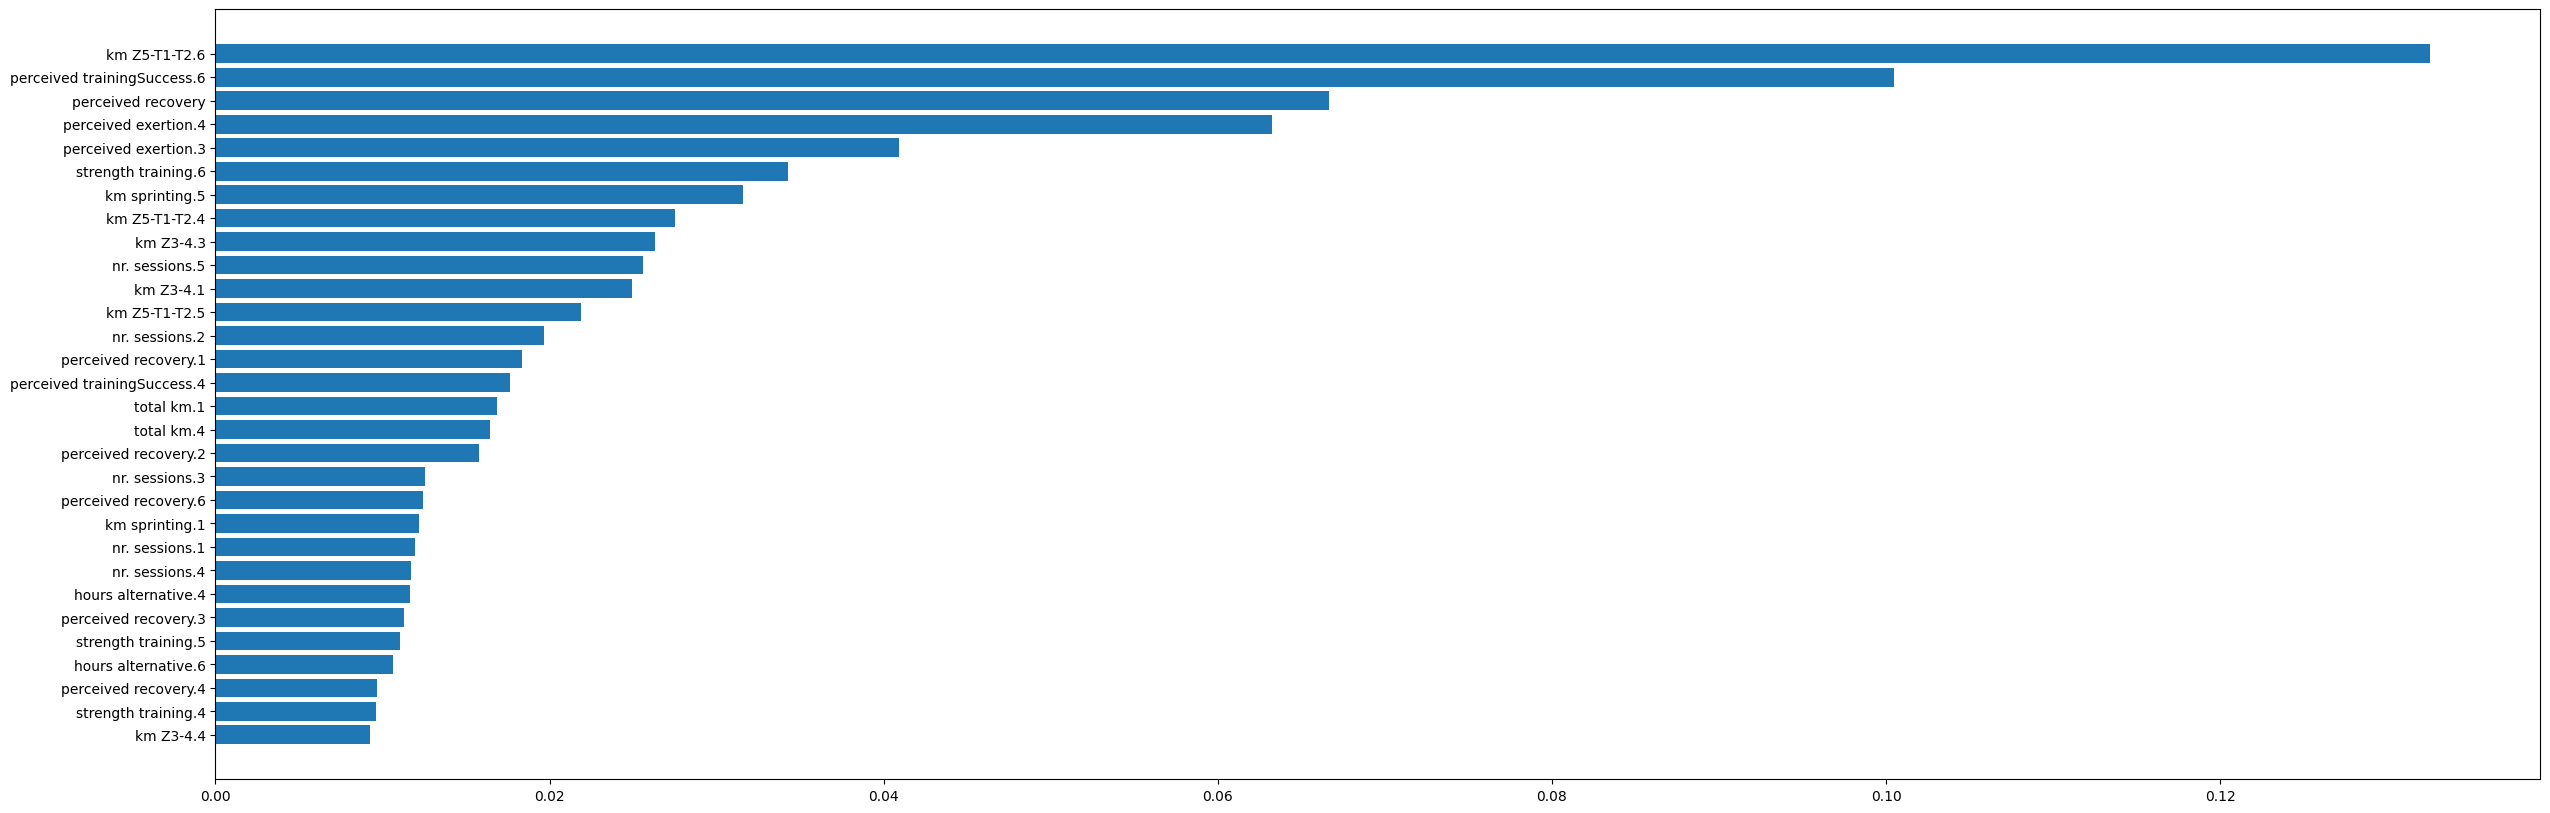

Approach = week, N = 10, nbags = 9, exp = 1
[0.79342911 0.69420174 0.7159519  0.73047428 0.70072144]
[0.66326115 0.72424182 0.73287241 0.72602538 0.71449566]
Approach = week, N = 10, nbags = 9, exp = 2
[0.79342911 0.780439   0.7159519  0.73047428 0.70072144]
[0.66326115 0.673899   0.73287241 0.72602538 0.71449566]
Approach = week, N = 10, nbags = 9, exp = 3
[0.79342911 0.780439   0.73016023 0.73047428 0.70072144]
[0.66326115 0.673899   0.67943209 0.72602538 0.71449566]
Approach = week, N = 10, nbags = 9, exp = 4
[0.79342911 0.780439   0.73016023 0.71781261 0.70072144]
[0.66326115 0.673899   0.67943209 0.66734075 0.71449566]
Approach = week, N = 10, nbags = 9, exp = 5
[0.79342911 0.780439   0.73016023 0.71781261 0.74178463]
[0.66326115 0.673899   0.67943209 0.66734075 0.66937001]


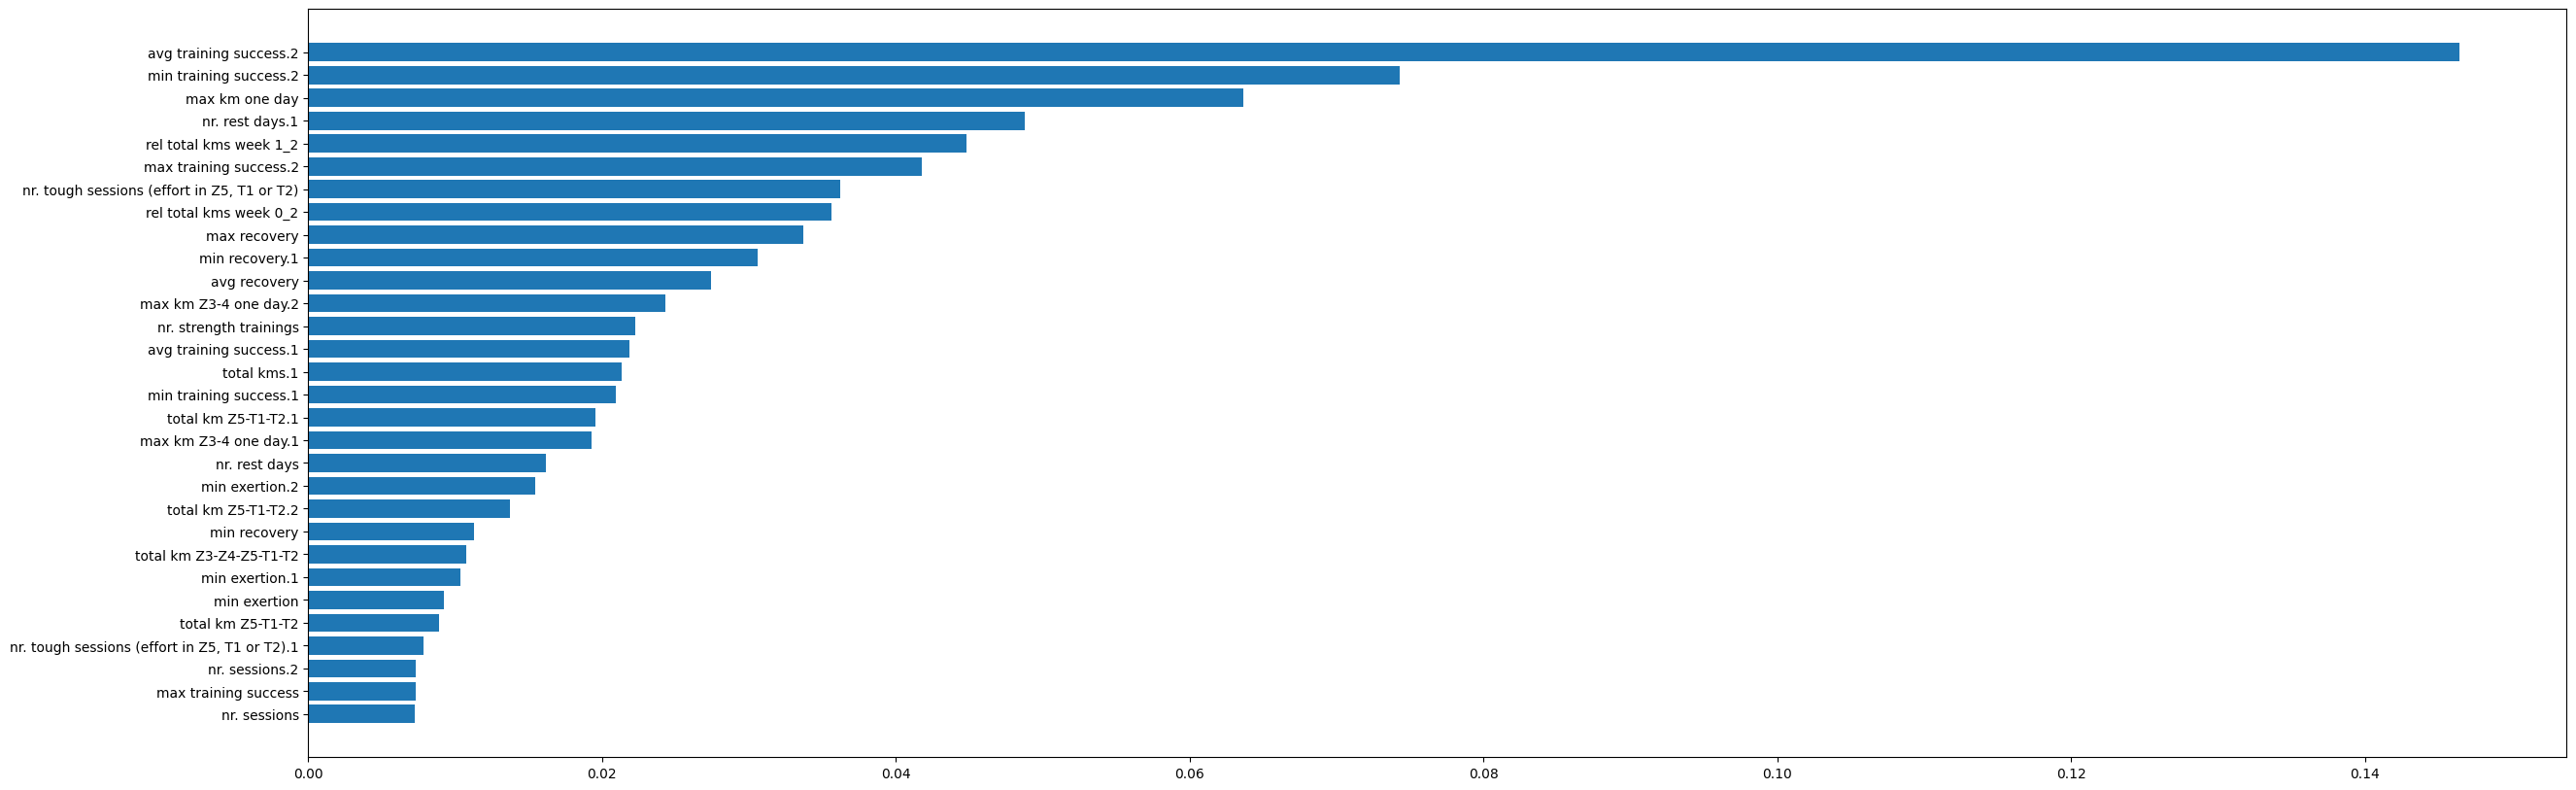

Plotting the calibration curves


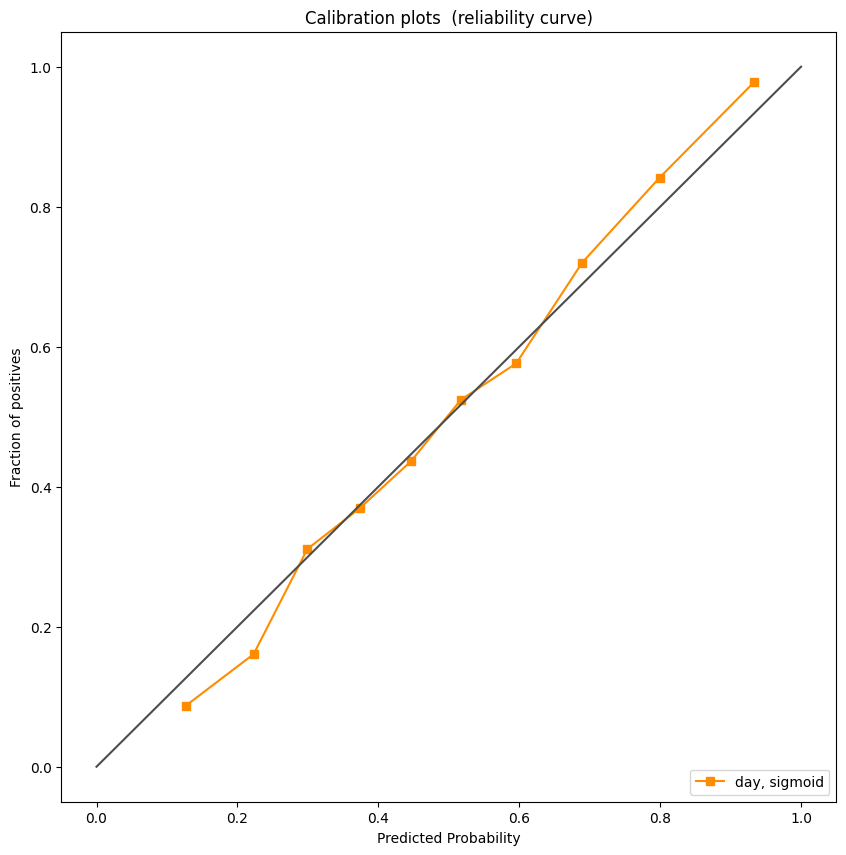

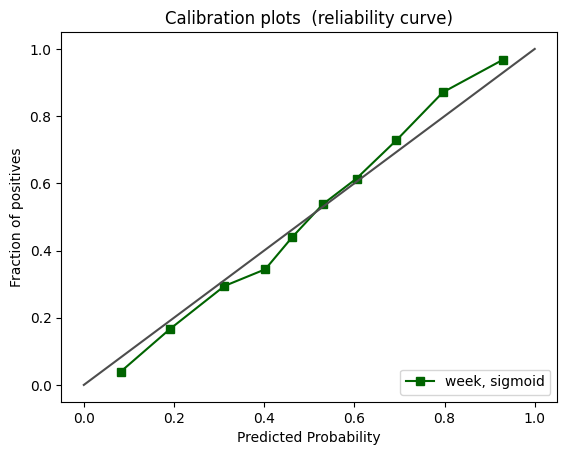

In [8]:
def main():
 
    params = {
        "nTestAthletes"    : 10,         # The number of the last athletese that joined the club used as the test set
        "nbags"            : 9,          # The number of XGBoost models
        "calibrationType"  : "sigmoid",  # The type of calibration - Platt scaling
        "nExp"             : 5,          # The number of experiments to run
        "samplesPerClass"  : 2048,       # The number of injury and non-injury samples taken to train each of the XGBoost models   
        "approachList"     : ["day", "week"],    # The two approaches (day or week)
        "XGBEstimatorsList": [256,512],
        "calibrateList"    : ["before", "after"],
        "XGBDepthList"     : [2,3] 
    }        
    
    val_fprList     = pd.DataFrame()
    val_tprList     = pd.DataFrame()
    test_fprList    = pd.DataFrame()
    test_tprList    = pd.DataFrame()    
    val_auc         = np.zeros(params["nExp"])
    test_auc        = np.zeros(params["nExp"])

    output_val           = [[0] * params["nExp"] for j in np.arange(0,len(params["approachList"]))]
    y_prediction    = [[0] * params["nExp"] for j in np.arange(0,len(params["approachList"]))]
    
    for approachidx, approach in enumerate(params["approachList"]):
        dirname = '/kaggle/working/'+'%s_%d' % (approach, params["samplesPerClass"])
        if not os.path.isdir(dirname):
            os.mkdir(dirname)

        for exp in np.arange(0,params["nExp"]):
            print("Approach = %s, N = %d, nbags = %d, exp = %d" %(approach,params["nTestAthletes"],params["nbags"],exp+1))
            featureRanking, featureNames, val_fpr, val_tpr, val_auc[exp], test_fpr, test_tpr, test_auc[exp], output_val[approachidx][exp], y_prediction[approachidx][exp] = runExperiment(params, approach, exp)
            print(val_auc)
            print(test_auc)
            if not path.exists("./%s_%d/featureranking.csv" % (approach, params["samplesPerClass"])):
                with open('./%s_%d/featureranking.csv' % (approach, params["samplesPerClass"]), 'w', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(featureNames)

            val_fprList['exp %d'  % exp] = val_fpr
            val_tprList['exp %d'  % exp] = val_tpr
            test_fprList['exp %d' % exp] = test_fpr
            test_tprList['exp %d' % exp] = test_tpr

            if (exp == 0):
                aggFeatureRanking = featureRanking
            else:
                aggFeatureRanking = aggFeatureRanking.add(featureRanking)

        plotROC(val_fprList.mean(axis = 1), val_tprList.mean(axis = 1), np.mean(val_auc), test_fprList.mean(axis = 1), test_tprList.mean(axis = 1), np.mean(test_auc), './%s_%d/N=%d_nbags=%d_ROC.pdf' %(approach,params["samplesPerClass"],params["nTestAthletes"],params["nbags"]))

        aggFeatureRanking = aggFeatureRanking.div(aggFeatureRanking.sum())
        with open('./%s_%d/featureranking.csv' % (approach, params["samplesPerClass"]), 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(aggFeatureRanking)

        rank = np.argsort(aggFeatureRanking)
        featureNames = [col for col in featureNames if col not in ({'injury','Date','Athlete ID'})]
        featureNames = [featureNames[i] for i in rank]

        plt.figure(figsize=(30,10))
        plt.barh(np.arange(30), aggFeatureRanking[rank[len(rank)-30:len(rank)]])
        plt.yticks(np.arange(30), featureNames[len(featureNames)-30:len(featureNames)])
        plt.savefig("./%s_%d/N=%d_nbags=%d_featureranking.pdf" %(approach,params["samplesPerClass"],params["nTestAthletes"],params["nbags"]))
        plt.show()
        plt.close()

    print("Plotting the calibration curves")
    plt.figure(100, figsize=(10, 10))
    colorlist = ["darkorange","darkgreen"]
    calibrateidx = 1
    for approachidx, approach in enumerate(params["approachList"]):
        fraction_of_positives_list = []
        mean_predicted_value_list = []

        for exp in np.arange(0,params["nExp"]):
            #plotCalibrationCurve(output_val[approachidx][calibrateidx][exp], y_prediction[approachidx][calibrateidx][exp],'%s_%s_%d_calibration.pdf' % (params["approachList"][approachidx], params["calibrateList"][calibrateidx], exp))
            fraction_of_positives, mean_predicted_value = calibration_curve(output_val[approachidx][exp], y_prediction[approachidx][exp], n_bins=10,strategy='quantile')
            fraction_of_positives_list.append(fraction_of_positives)
            mean_predicted_value_list.append(mean_predicted_value)

        plt.plot(np.mean(mean_predicted_value_list,axis=0), np.mean(fraction_of_positives_list,axis=0), "s", color="%s" %(colorlist[approachidx]), ls="-", label="%s, %s" % (approach,params["calibrationType"]))
        plt.plot([0, 1], [0, 1], ls="-", c="0.3")
        plt.ylabel("Fraction of positives")
        plt.xlabel("Predicted Probability")
        plt.ylim([-0.05, 1.05])
        plt.xlim([-0.05, 1.05])
        plt.legend(loc="lower right")
        plt.title('Calibration plots  (reliability curve)')
        plt.show()
    plt.savefig("calibration.pdf")
    plt.close()

main()